In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [ ]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
audio, sr = librosa.load('drive/MyDrive/ser_scoring_audio_question2.wav')
print(sr)
# Get number of samples for 2 seconds; replace 2 by any number
buffer = 3 * sr

samples_total = len(audio)
samples_wrote = 0
counter = 1
lst =[]
while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples 
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote

    block = audio[samples_wrote : (samples_wrote + buffer)]
    lst.append(block)
    # Write 2 second segment
    counter += 1
    samples_wrote += buffer

22050


Text(0.5, 0, 'Seconds')

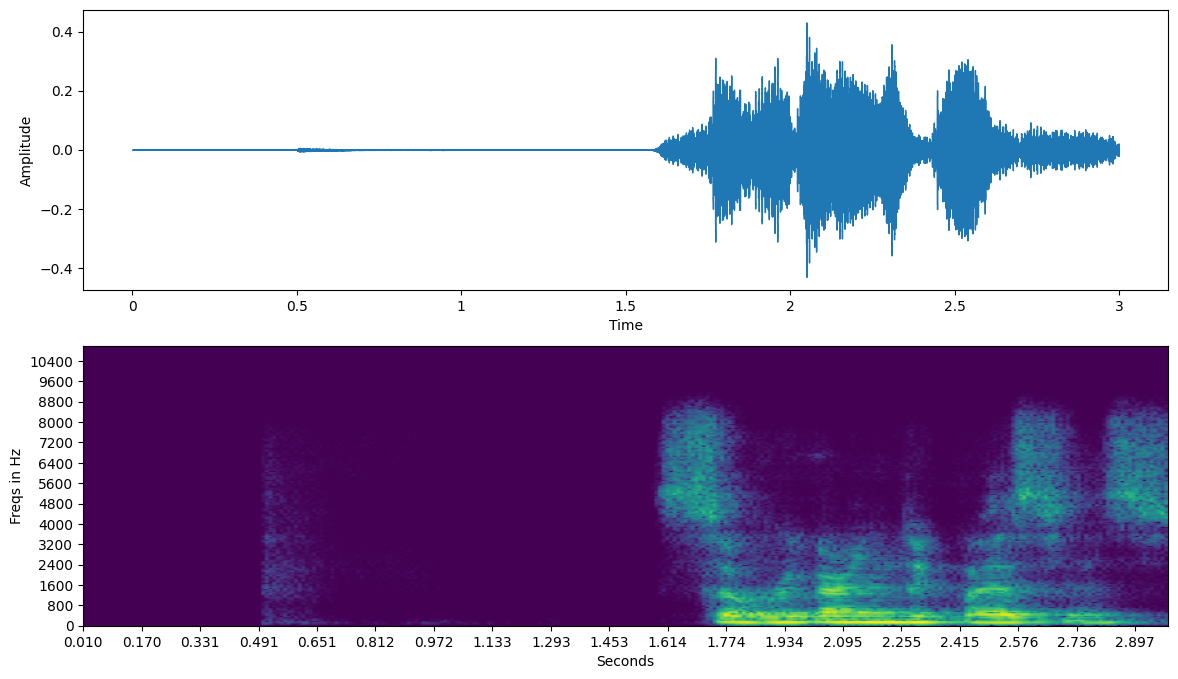

In [ ]:
freqs, times, spectrogram = log_specgram(lst[0], sr)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
#ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(lst[0], sr=sr)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
#ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
ipd.Audio(lst[0], rate=sr)
ipd.Audio(lst[1], rate=sr)

In [ ]:
data_test = pd.DataFrame(columns=['feature'])

X, sample_rate = librosa.load('drive/MyDrive/ser_scoring_audio_question2.wav', res_type='kaiser_fast', sr=22050*2,offset=0.5)
#     X = X[10000:90000]
sr = np.array(sample_rate)
print(X.shape,sample_rate)
buffer = 3 * sample_rate
print(buffer)
samples_total = len(audio)
print(samples_total)
samples_wrote = 0
counter = 0
lst = []
while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples 
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote

    block = X[samples_wrote : (samples_wrote + buffer)]
    lst.append(block)
    # Write 2 second segment
    samples_wrote += buffer
    mfccs = np.mean(librosa.feature.mfcc(y=block, sr=sr, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[counter] = [feature]
    counter += 1

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)

#test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
#test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)
print(test_valid.shape)

(1716702,) 44100
132300
869376
(7, 259, 1)


In [ ]:
ipd.Audio(lst[0], rate=sample_rate)


Text(0.5, 0, 'Seconds')

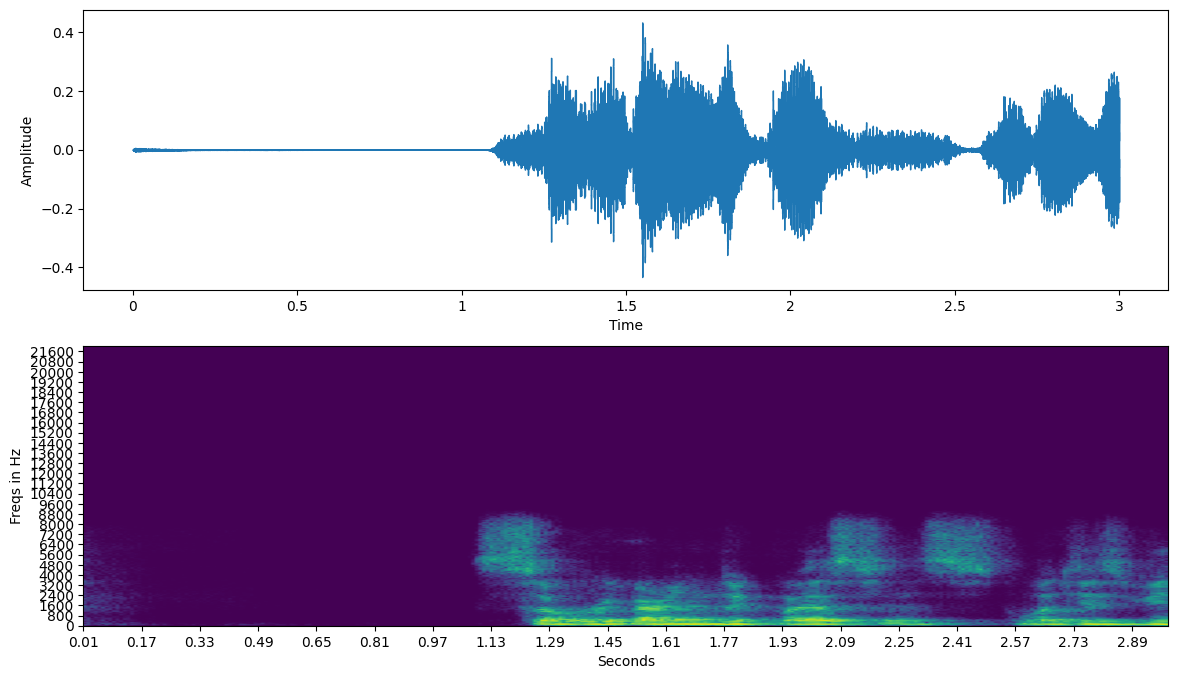

In [ ]:
freqs, times, spectrogram = log_specgram(X, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
#ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(X, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
#ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
samples, sample_rate = librosa.load('drive/MyDrive/ser_scoring_audio_question2.wav')
print(sample_rate). # this returned 22050

ipd.Audio(samples, rate=sample_rate)

22050 [-1.2170585e-07 -1.5612783e-05  1.5712781e-06 ...  4.0305691e-05
  2.4895286e-05  5.7802376e-05]


NameError: ignored

In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)
preds=preds.argmax(axis=1)

1/1 [==============================] - 0s 66ms/step


array([2, 2, 2, 0, 2, 2, 0])

In [2]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
import pandas as pd
import librosa
import numpy as np


# load the deep learning model here
loaded_model = tf.keras.models.load_model("drive/MyDrive/Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# load and process the speech here
data_test = pd.DataFrame(columns=['feature'])

speech, sample_rate = librosa.load('drive/MyDrive/ser_scoring_audio_question2.wav', res_type='kaiser_fast', sr=22050*2,offset=0.5)
#     X = X[10000:90000]
sr = np.array(sample_rate)
print(speech.shape,sample_rate)
buffer = 3 * sample_rate
# print(buffer)
samples_total = len(speech)
print(samples_total)
samples_wrote = 0
counter = 0
lst = []
while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote

    block = speech[samples_wrote : (samples_wrote + buffer)]
    lst.append(block)
    # Write 2 second segment
    samples_wrote += buffer
    mfccs = np.mean(librosa.feature.mfcc(y=block, sr=sr, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[counter] = [feature]
    counter += 1

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)

test_valid = np.expand_dims(test_valid, axis=2)
print(test_valid.shape)

preds = loaded_model.predict(test_valid,
                         batch_size=16,
                         verbose=1)
print(preds.shape)
preds = preds.argmax(axis=1)
print(preds)
class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
mode_pred = np.max(preds)

count_emotions = np.unique(preds, return_counts = True)
for i, emotion in enumerate(count_emotions[0]):
    print(class_names[emotion], count_emotions[1][i]/len(preds))

print(class_names[mode_pred])

Loaded model from disk
(1716702,) 44100
1716702
(13, 259, 1)
1/1 [==============================] - 1s 562ms/step
(13, 5)
[2 2 2 0 2 2 2 0 0 0 2 0 2]
male_angry 0.38461538461538464
male_fearful 0.6153846153846154
male_fearful


In [3]:
speech, sample_rate = librosa.load('drive/MyDrive/ser_scoring_audio_question2.wav', res_type='kaiser_fast', sr=22050*2,offset=0.5)

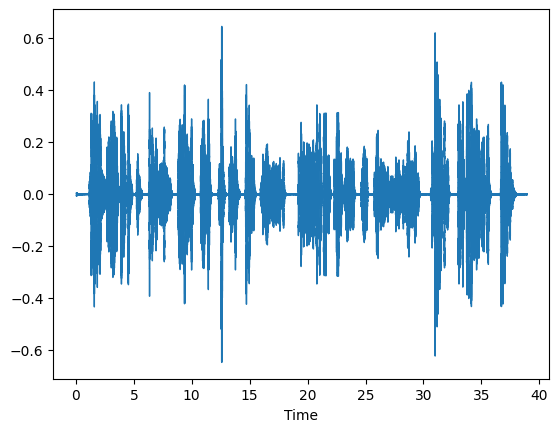

In [8]:
librosa.display.waveshow(speech,sr=sample_rate, axis='time', offset=0.0)


In [9]:
mfcc = librosa.feature.mfcc(y=speech, sr=sample_rate, hop_length=512, n_mfcc=13)


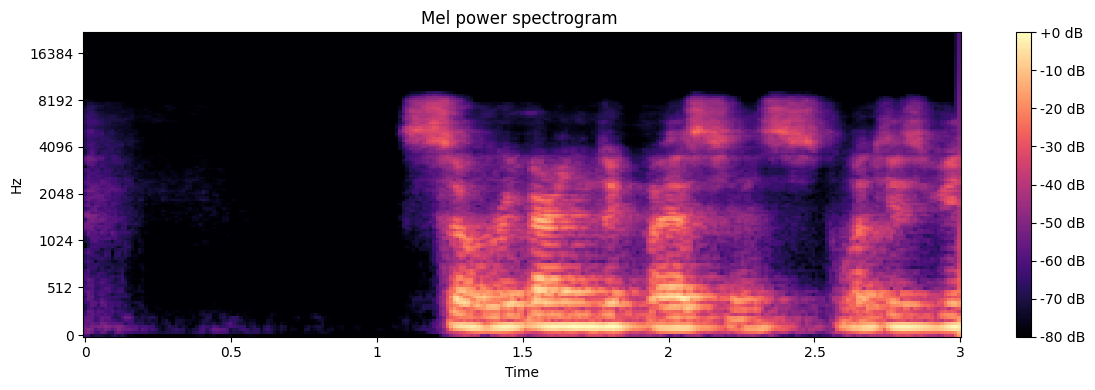

In [14]:
# Plotting Mel Power Spectrogram
import matplotlib.pyplot as plt
S = librosa.feature.melspectrogram(y = lst[0], sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [13]:
import IPython.display as ipd
ipd.Audio(lst[0], rate=sample_rate)

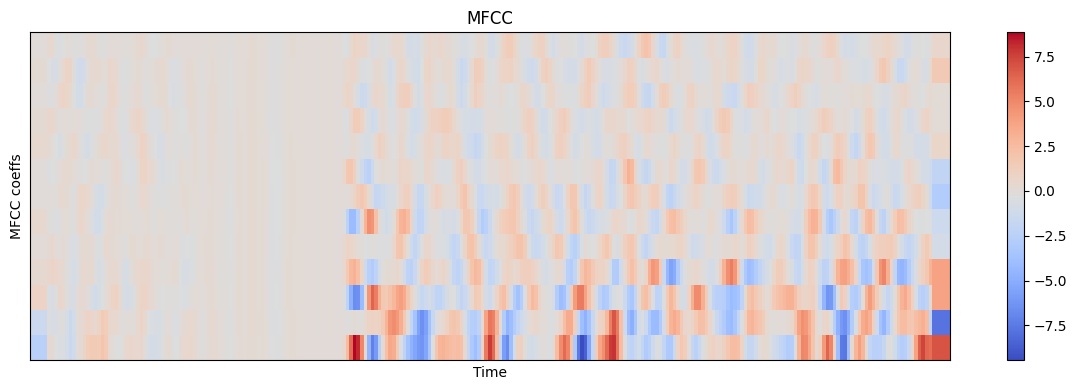

In [19]:
mfcc = librosa.feature.mfcc(y=lst[0], n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [20]:
ls

drive/  sample_data/


In [21]:
path = 'drive/Mydrive/speech'

In [43]:
speech, sample_rate = librosa.load('drive/MyDrive/speech_data/ser_scoring_audio_question3 (1).wav', res_type='kaiser_fast', sr=22050*2,offset=0.5)

In [44]:
ipd.Audio(speech, rate=sample_rate)

In [45]:
# load and process the speech here
data_test = pd.DataFrame(columns=['feature'])

speech, sample_rate = librosa.load('drive/MyDrive/speech_data/ser_scoring_audio_question3 (1).wav', res_type='kaiser_fast', sr=22050*2,offset=0.5)
#     X = X[10000:90000]
sr = np.array(sample_rate)
print(speech.shape,sample_rate)
buffer = 3 * sample_rate
# print(buffer)
samples_total = len(speech)
print(samples_total)
samples_wrote = 0
counter = 0
lst = []
while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote

    block = speech[samples_wrote : (samples_wrote + buffer)]
    lst.append(block)
    # Write 2 second segment
    samples_wrote += buffer
    mfccs = np.mean(librosa.feature.mfcc(y=block, sr=sr, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[counter] = [feature]
    counter += 1

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)

test_valid = np.expand_dims(test_valid, axis=2)
print(test_valid.shape)

preds = loaded_model.predict(test_valid,
                         batch_size=16,
                         verbose=1)
print(preds.shape)
preds = preds.argmax(axis=1)
print(preds)
class_names = ['angry', 'calm', 'fearful', 'happy', 'sad']
mode_pred = np.max(preds)

count_emotions = np.unique(preds, return_counts = True)
for i, emotion in enumerate(count_emotions[0]):
    print(class_names[emotion], count_emotions[1][i]/len(preds))

print(class_names[mode_pred])

(357854,) 44100
357854
(3, 259, 1)
1/1 [==============================] - 0s 58ms/step
(3, 5)
[4 3 0]
angry 0.3333333333333333
happy 0.3333333333333333
sad 0.3333333333333333
sad
